Reference: how radars work -- https://encyclopedia.pub/entry/23781

In [1]:
# Def functions for samples splitting and padding

def pad_r(data, i, j):
    delta = j-i
    if delta < 120:
        temp = np.pad(data[i:j,:,:],((0,120-delta),(0,0),(0,0)),'edge')
    else:
        temp = data[j-120:j,:,:]
    return np.expand_dims(temp, axis=0)

def pad_md(data, i, j):
    delta = j-i
    if delta < 120:
        temp = np.pad(data[i:j,:],((0,120-delta),(0,0)),'edge')
    else:
        temp = data[j-120:j,:]
    return np.expand_dims(temp, axis=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import h5py
import numpy as np
from PIL import Image as im
import pandas as pd
%matplotlib inline 
filename = "/content/drive/MyDrive/PatientActivityRecognition/data/processed_data_00_00.h5"
fp = 11.1

In [14]:
# Read h5 file

f = h5py.File(filename, 'r')
datar = f['radar']['TI_xWR14xx']['rdn']
datamd = f['radar']['TI_xWR14xx']['mDoppler']

KeyError: ignored

In [ ]:
# Filter: remove end of room, central signal of doppler (static objects)
datar_t = datar[:,:-30,:] # [:,:-30,13:-14]
l2=int(np.trunc(datar_t.shape[2]/2))
datar_filtered = np.append(datar_t[:,:,:l2-1],datar_t[:,:,l2+2:], axis=2)
datamd_filtered = np.append(datamd[:,:l2-1],datamd[:,l2+2:], axis=1)

In [ ]:
# Load labels and timestamps
df = pd.read_csv('timestamp_speech.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])#.astype(int)
print(df)
df['timestamp'] = np.round((df['timestamp']-df['timestamp'][0]).dt.total_seconds()*fp)
print(df)
idx = np.array(df['timestamp'], dtype='int')
label = df['command']

                    timestamp                command
0  2019-11-25 16:51:37.709373          walk to chair
1  2019-11-25 16:51:46.982593      sit down on chair
2  2019-11-25 16:51:54.581688    stand up from chair
3  2019-11-25 16:52:01.100477           walk to room
4  2019-11-25 16:52:13.360816  fall on floor of room
..                        ...                    ...
81 2019-11-25 17:01:07.793530             sit in bed
82 2019-11-25 17:01:13.903068           get out  bed
83 2019-11-25 17:01:21.709568          walk to chair
84 2019-11-25 17:01:32.107657      sit down on chair
85 2019-11-25 17:01:37.391179    stand up from chair

[86 rows x 2 columns]
    timestamp                command
0         0.0          walk to chair
1       103.0      sit down on chair
2       187.0    stand up from chair
3       260.0           walk to room
4       396.0  fall on floor of room
..        ...                    ...
81     6328.0             sit in bed
82     6396.0           get out  bed
83     6

In [ ]:
# Check the intervals
idx = np.append(idx, datar_filtered.shape[0])
idx[1:]-idx[:-1]

array([103,  84,  73, 136,  76,  89,  69,  55,  61, 110,  54,  77,  57,
        79,  46, 109,  56,  63,  68,  74,  61,  47, 167,  77, 101,  84,
        65, 104,  58,  91,  87,  70,  69,  55, 100,  70,  58, 123,  61,
        85,  48,  86,  50,  86,  82, 111,  62,  97,  64,  80,  63,  67,
       100,  59,  96,  58,  91,  67,  89,  80,  92,  85, 108,  68,  57,
        77,  67,  57,  83,  48,  95,  88,  48,  41, 166,  48,  83,  57,
        93,  91,  68,  68,  86, 116,  58,  20])

In [ ]:
idx.shape

(87,)

In [ ]:
# Split radar into tasks
rdn = pad_r(datar_filtered, 0, idx[1])
print(rdn.shape)
for i, j in zip(idx[1:-1], idx[2:]):
    rdn = np.append(rdn,pad_r(datar_filtered, i, j),axis=0)
print(rdn.shape)

(1, 120, 63, 125)
(86, 120, 63, 125)


In [ ]:
# Split mDoppler into tasks
md = pad_md(datamd_filtered, 0, idx[1])
print(md.shape)
for i, j in zip(idx[1:-1], idx[2:]):
    md = np.append(md,pad_md(datamd_filtered, i, j),axis=0)
print(md.shape)

(1, 120, 125)
(86, 120, 125)


In [ ]:
#Check the labels
np.array(label)

array(['walk to chair', 'sit down on chair', 'stand up from chair',
       'walk to room', 'fall on floor of room',
       'stand up from floor of room', 'walk to bed', 'sit down on bed',
       'stand up from bed', 'walk to room', 'fall on floor of room',
       'stand up from floor of room', 'walk to bed', 'get in  bed',
       'sit in bed', 'roll in bed', 'lie in bed', 'sit in bed',
       'get out  bed', 'walk to chair', 'sit down on chair',
       'stand up from chair', 'walk to bed', 'get in  bed', 'roll in bed',
       'get out  bed', 'walk to chair', 'walk to room',
       'fall on floor of room', 'stand up from floor of room',
       'walk to chair', 'walk to bed', 'sit down on bed',
       'stand up from bed', 'walk to chair', 'sit down on chair',
       'stand up from chair', 'walk to room', 'fall on floor of room',
       'stand up from floor of room', 'walk to bed', 'get in  bed',
       'lie in bed', 'get out  bed', 'walk to chair', 'walk to room',
       'fall on floor o

In [ ]:
# Print the pre processed file
fout = h5py.File(filename[:-3]+'_pp.h5', 'w')
fout.create_dataset('rdn', data=rdn)
fout.create_dataset('mDoppler', data=md)
fout.create_dataset('label', data=np.array(label, dtype='S'))
fout.close()
f.close()

In [ ]:
# Check contents of printed file
f = h5py.File(filename[:-3]+'_pp.h5', 'r')
datar = f['rdn']
datamd = f['mDoppler']
datal = f['label']

In [ ]:
np.array(datal, dtype='str')[0]

'walk to bed'

In [ ]:
f.close()

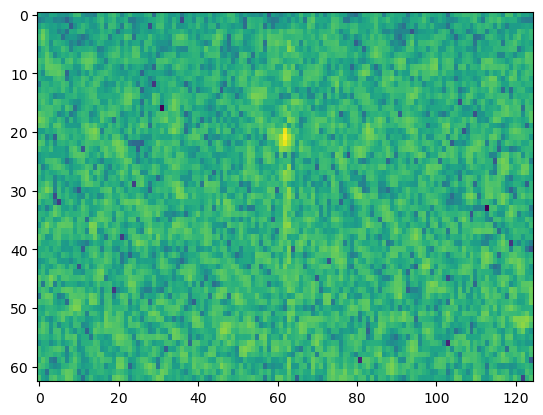

In [ ]:
# Visualize radar
from matplotlib import pyplot as plt
plt.imshow(datar[2,12], interpolation='nearest', aspect='auto')
plt.show()

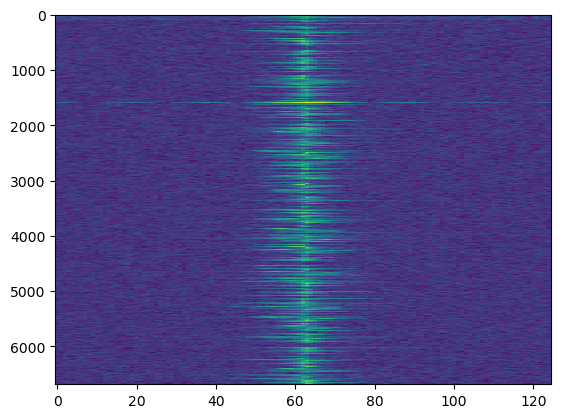

In [ ]:
# Visualize mDoppler
from matplotlib import pyplot as plt
plt.imshow(datamd_filtered, interpolation='nearest', aspect='auto')
plt.show()

# -------- Old stuff ----------

In [ ]:
def get_all(name):
    print(name)

In [ ]:
f.visit(get_all)

radar
radar/TI_xWR68xx
radar/TI_xWR68xx/cube
radar/TI_xWR68xx/mDoppler
radar/TI_xWR68xx/rdn


In [ ]:
hdfid.visititems(get_all_objs)

radar <HDF5 group "/radar" (2 members)> []
radar/TI_xWR14xx <HDF5 group "/radar/TI_xWR14xx" (3 members)> []
radar/TI_xWR14xx/cube <HDF5 dataset "cube": shape (6684, 128, 1, 16, 93), type "<f4"> []
radar/TI_xWR14xx/mDoppler <HDF5 dataset "mDoppler": shape (6684, 128), type "<f4"> []
radar/TI_xWR14xx/rdn <HDF5 dataset "rdn": shape (6684, 93, 128), type "<f4"> []
radar/TI_xWR68xx <HDF5 group "/radar/TI_xWR68xx" (3 members)> []
radar/TI_xWR68xx/cube <HDF5 dataset "cube": shape (6685, 128, 1, 16, 93), type "<f4"> []
radar/TI_xWR68xx/mDoppler <HDF5 dataset "mDoppler": shape (6685, 128), type "<f4"> []
radar/TI_xWR68xx/rdn <HDF5 dataset "rdn": shape (6685, 93, 128), type "<f4"> []
